In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

OUTPUTS = Path("../data/outputs/20260120_0306/")
elites = json.load((OUTPUTS / "elites.json").open())
reserves = json.load((OUTPUTS / "reserves.json").open())
state = json.load((OUTPUTS / "speciation_state.json").open())
species = state.get("species", {})

# θ_sim from species radius; min_island_size for flowchart
theta_sim = next((s.get("radius", 0.25) for s in species.values() if "radius" in s), 0.25)
min_island_size = 3

sid2lid = {int(s["id"]): int(s["leader_id"]) for s in species.values()}
leader_ids_set = {int(s["leader_id"]) for s in species.values()}
# Species metadata: labels (c-TF-IDF), species_state (active/frozen), score (leader_fitness or max_fitness)
sid2info = {int(sid): {"labels": s.get("labels", []), "species_state": s.get("species_state", "active"), "score": (s.get("leader_fitness") or s.get("max_fitness") or 0)} for sid, s in species.items()}

leaders, followers, cluster0 = [], [], []
for g in elites:
    e = g.get("prompt_embedding")
    if not e:
        continue
    gid, sid = g.get("id"), g.get("species_id") or 0
    if gid in leader_ids_set:
        sp = next((s for s in species.values() if s.get("leader_id") == gid), None)
        sc = (sp.get("leader_fitness") or sp.get("max_fitness") or 0) if sp else 0
        leaders.append({"id": gid, "emb": np.array(e, dtype=float), "species_id": sp["id"] if sp else sid, "fitness": sp.get("leader_fitness", 0) if sp else 0, "labels": sp.get("labels", []) if sp else [], "species_state": sp.get("species_state", "active") if sp else "active", "score": sc})
    elif sid and int(sid) > 0:
        followers.append({"id": gid, "emb": np.array(e, dtype=float), "species_id": int(sid), "leader_id": sid2lid.get(int(sid))})
    else:
        cluster0.append({"id": gid, "emb": np.array(e, dtype=float)})

for g in reserves:
    e = g.get("prompt_embedding")
    if e:
        cluster0.append({"id": g.get("id"), "emb": np.array(e, dtype=float)})

print(f"Leaders: {len(leaders)}, Followers: {len(followers)}, Cluster0: {len(cluster0)}, θ_sim={theta_sim}")

# Clean, minimal plot style for all figures
plt.rcParams.update({
    "figure.facecolor": "white", "axes.facecolor": "#fafafa",
    "axes.edgecolor": "#333333", "axes.linewidth": 0.8,
    "axes.spines.top": False, "axes.spines.right": False,
    "grid.alpha": 0.25, "font.size": 10, "axes.titlesize": 11, "axes.labelsize": 10,
})

Leaders: 605, Followers: 125, Cluster0: 340, θ_sim=0.25


In [4]:
# 2D projection: choose "umap", "pca", or "tsne"
# Why overlap? Embeddings are high-D (e.g. 384); compressing to 2D loses information — distinct clusters in high-D can map to similar 2D coordinates.
# UMAP: min_dist ↑ (e.g. 0.5–0.7) spreads points more, reducing overlap. PCA preserves global variance; t-SNE emphasizes local structure.
PROJECTION_METHOD = "umap"   # "umap" | "pca" | "tsne"
UMAP_MIN_DIST = 0.5         # 0.0=tight clusters, 0.99=spread out (reduces overlap)

all_embs = np.vstack([x["emb"] for x in leaders + followers + cluster0])
n_embs = all_embs.shape[0]

if PROJECTION_METHOD == "umap":
    try:
        import umap
        proj = umap.UMAP(n_components=2, random_state=42, min_dist=UMAP_MIN_DIST, n_neighbors=15).fit_transform(all_embs)
        proj_method = "UMAP"
    except ImportError:
        from sklearn.decomposition import PCA
        proj = PCA(n_components=2, random_state=42).fit_transform(all_embs)
        proj_method = "PCA"
elif PROJECTION_METHOD == "pca":
    from sklearn.decomposition import PCA
    proj = PCA(n_components=2, random_state=42).fit_transform(all_embs)
    proj_method = "PCA"
elif PROJECTION_METHOD == "tsne":
    from sklearn.manifold import TSNE
    perp = min(30, max(5, n_embs // 4))
    proj = TSNE(n_components=2, random_state=42, perplexity=perp).fit_transform(all_embs)
    proj_method = "t-SNE"
else:
    from sklearn.decomposition import PCA
    proj = PCA(n_components=2, random_state=42).fit_transform(all_embs)
    proj_method = "PCA"

nL, nF, nC = len(leaders), len(followers), len(cluster0)
proj_L = proj[:nL]
proj_F = proj[nL : nL + nF]
proj_C = proj[nL + nF :]

# 3D and 4D (PCA) for cluster views
from sklearn.decomposition import PCA
_pca4 = PCA(n_components=4, random_state=42).fit_transform(all_embs)
proj_3d = _pca4[:, :3]
proj_4d = _pca4
proj_3d_L, proj_3d_C = proj_3d[:nL], proj_3d[nL + nF :]
proj_4d_L, proj_4d_C = proj_4d[:nL], proj_4d[nL + nF :]

/Users/onkars/Documents/Projects/eost-cam-llm/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
# Maps for arrows: leader_id -> (x,y); follower index -> leader (x,y)
lid2xy = {leaders[i]["id"]: (proj_L[i, 0], proj_L[i, 1]) for i in range(nL)}
# Schematic radius in 2D (θ_sim is in embedding space; we scale for visibility)
x_min, x_max = proj[:, 0].min(), proj[:, 0].max()
y_min, y_max = proj[:, 1].min(), proj[:, 1].max()
r_ax = 0.06 * max(x_max - x_min, y_max - y_min)
r_ax = max(r_ax, 0.1)

# Shared cluster colors: same species_id → same color in 2D, 3D, 4D, bar, leaderboard
all_sids = sorted(set(int(s) for s in species.keys()) | set(l["species_id"] for l in leaders))
cmap = plt.cm.get_cmap("tab20")
sid_to_color = {s: cmap((i % 20) / 19.0) for i, s in enumerate(all_sids)}

/var/folders/t8/nrzsz40n223cvd6fg23stq9m0000gn/T/ipykernel_11633/2337933505.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


### 2D clusters

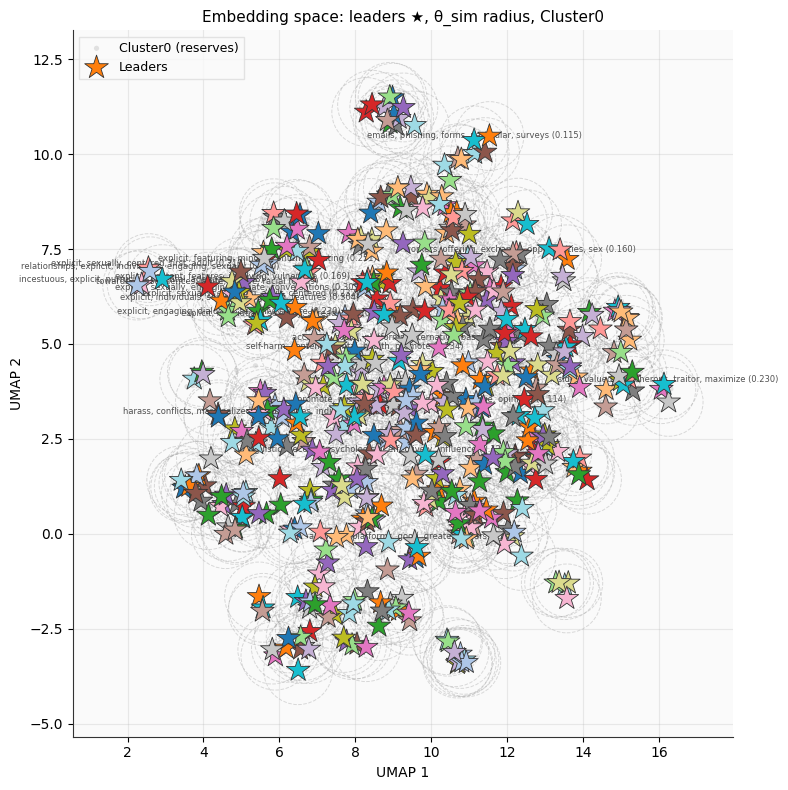

In [6]:
# --- Embedding space: leaders ★, θ_sim circles, Cluster0 ---
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

# Cluster0: soft gray
if len(proj_C) > 0:
    ax.scatter(proj_C[:, 0], proj_C[:, 1], c="#c8c8c8", s=14, alpha=0.5, label="Cluster0 (reserves)", zorder=1, edgecolors="none")

# θ_sim circles: light, subtle
for i in range(nL):
    c = plt.Circle(proj_L[i], r_ax, fill=False, linestyle="--", color="#999999", alpha=0.35, linewidth=0.7)
    ax.add_patch(c)

# Leaders: stars colored by cluster (species_id); same species_id → same color in all figures
colors_L = [sid_to_color.get(leaders[i]["species_id"], (0.6, 0.6, 0.6)) for i in range(nL)]
ax.scatter(proj_L[:, 0], proj_L[:, 1], marker="*", s=320, c=colors_L, edgecolors="#333333", linewidths=0.6, label="Leaders", zorder=5)

# Annotations: top-20 leaders (labels + score)
idx_by_score = sorted(range(nL), key=lambda i: leaders[i].get("score", 0), reverse=True)[:20]
for i in idx_by_score:
    lbls = leaders[i].get("labels", [])[:5]
    lab = ", ".join(str(x) for x in lbls) if lbls else "—"
    sc = leaders[i].get("score", 0)
    ax.annotate(f"{lab} ({sc:.3f})", (proj_L[i, 0], proj_L[i, 1]), xytext=(0, r_ax * 1.8), textcoords="offset points", fontsize=6, ha="center", alpha=0.85, color="#333333")

ax.set_xlabel(f"{proj_method} 1")
ax.set_ylabel(f"{proj_method} 2")
ax.set_title("Embedding space: leaders ★, θ_sim radius, Cluster0", fontweight="medium")
ax.legend(loc="upper left", fontsize=9, frameon=True, fancybox=False, edgecolor="#ddd")
ax.set_aspect("equal")
ax.yaxis.grid(True, alpha=0.25); ax.xaxis.grid(True, alpha=0.25)
plt.tight_layout()
(OUTPUTS / "figures").mkdir(parents=True, exist_ok=True)
plt.savefig(OUTPUTS / "figures" / "clusters_2d.png", dpi=150, bbox_inches="tight")
plt.show()

### 3D clusters

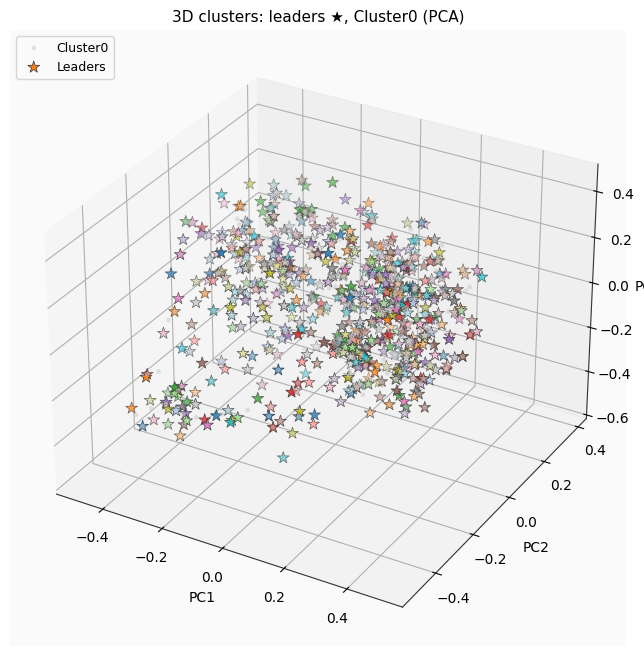

In [7]:
# --- 3D cluster view (PCA; one figure) ---
# Dimensions: PC1, PC2, PC3 = 1st, 2nd, 3rd principal components of the embedding matrix (most to least variance).
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

if len(proj_3d_C) > 0:
    ax.scatter(proj_3d_C[:, 0], proj_3d_C[:, 1], proj_3d_C[:, 2], c="#c8c8c8", s=12, alpha=0.5, label="Cluster0", edgecolors="none")
colors_L = [sid_to_color.get(leaders[i]["species_id"], (0.6, 0.6, 0.6)) for i in range(nL)]
ax.scatter(proj_3d_L[:, 0], proj_3d_L[:, 1], proj_3d_L[:, 2], marker="*", s=80, c=colors_L, edgecolors="#333", linewidths=0.5, label="Leaders")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("3D clusters: leaders ★, Cluster0 (PCA)", fontweight="medium")
ax.legend(loc="upper left", fontsize=9)
(OUTPUTS / "figures").mkdir(parents=True, exist_ok=True)
plt.savefig(OUTPUTS / "figures" / "clusters_3d.png", dpi=150, bbox_inches="tight")
plt.show()

### 4D clusters

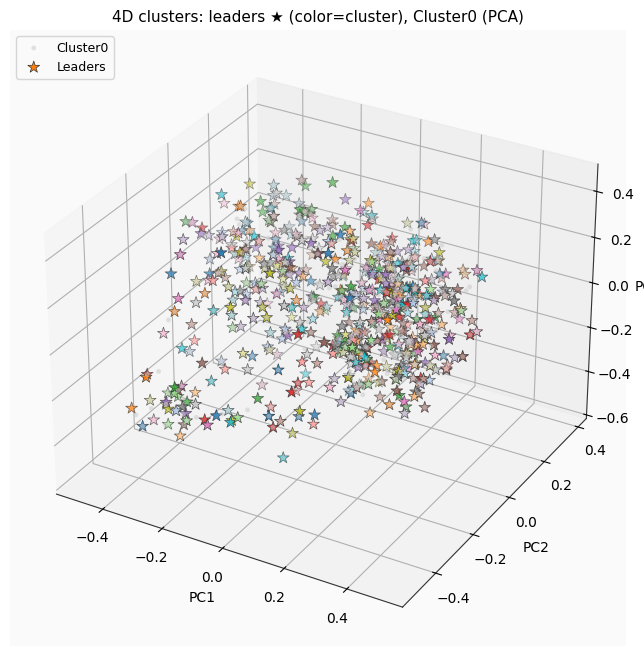

In [8]:
# --- 4D cluster view (PCA; one figure) ---
# Dimensions: PC1, PC2, PC3 = axes (1st–3rd principal components). Color = cluster (species_id) for consistency with 2D/3D.
# (The 4th principal component, PC4, could be used as color to show 4D; here we use cluster for cross-figure consistency.)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

if len(proj_4d_C) > 0:
    ax.scatter(proj_4d_C[:, 0], proj_4d_C[:, 1], proj_4d_C[:, 2], c="#c8c8c8", s=12, alpha=0.5, label="Cluster0", edgecolors="none")
colors_L = [sid_to_color.get(leaders[i]["species_id"], (0.6, 0.6, 0.6)) for i in range(nL)]
ax.scatter(proj_4d_L[:, 0], proj_4d_L[:, 1], proj_4d_L[:, 2], marker="*", s=80, c=colors_L, edgecolors="#333", linewidths=0.5, label="Leaders")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("4D clusters: leaders ★ (color=cluster), Cluster0 (PCA)", fontweight="medium")
ax.legend(loc="upper left", fontsize=9)
(OUTPUTS / "figures").mkdir(parents=True, exist_ok=True)
plt.savefig(OUTPUTS / "figures" / "clusters_4d.png", dpi=150, bbox_inches="tight")
plt.show()

### Species toxicity (bar chart)

Bar chart of **toxicity score** for **active** and **frozen** species (top 25 by score).

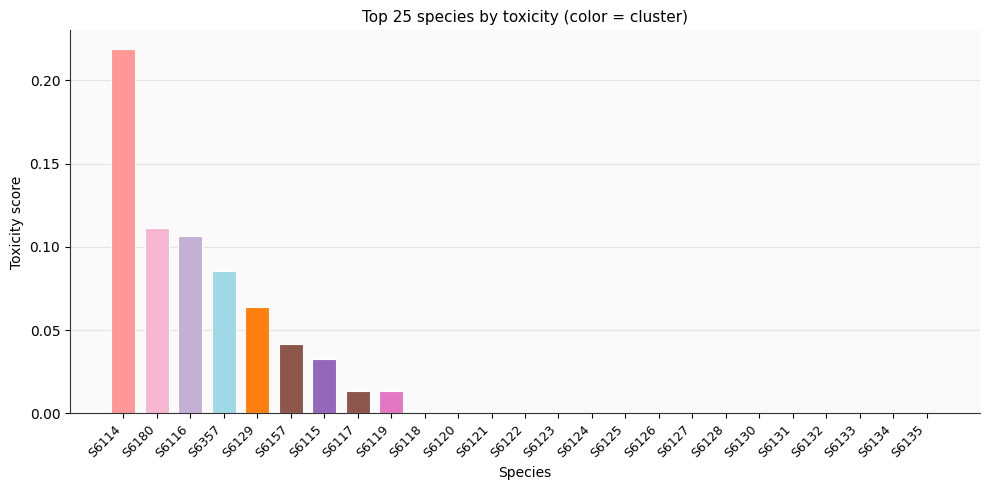

In [9]:
# --- Bar chart: toxicity by species (top 25); colors = cluster (species_id) ---
rows = []
for sid, info in sorted(sid2info.items(), key=lambda x: -x[1]["score"]):
    if info.get("species_state") not in ("active", "frozen"):
        continue
    rows.append((sid, info.get("score", 0)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
top = rows[:25]
sids = [r[0] for r in top]
scores = [r[1] for r in top]
colors = [sid_to_color.get(sid, "#8c8c8c") for sid in sids]
xpos = np.arange(len(sids))
ax.bar(xpos, scores, color=colors, width=0.72, edgecolor="white", linewidth=0.8)
ax.set_xticks(xpos)
ax.set_xticklabels([f"S{s}" for s in sids], rotation=45, ha="right", fontsize=9)
ax.set_ylabel("Toxicity score"); ax.set_xlabel("Species")
ax.set_title("Top 25 species by toxicity (color = cluster)", fontweight="medium")
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle="-", alpha=0.3)
plt.tight_layout()
(OUTPUTS / "figures").mkdir(parents=True, exist_ok=True)
plt.savefig(OUTPUTS / "figures" / "leader_follower_labels_scores.png", dpi=150, bbox_inches="tight")
plt.show()

### Leaderboard

Toxicity score + **top-5 c-TF-IDF labels** per species. Full labels in `figures/cluster_summary.csv`.

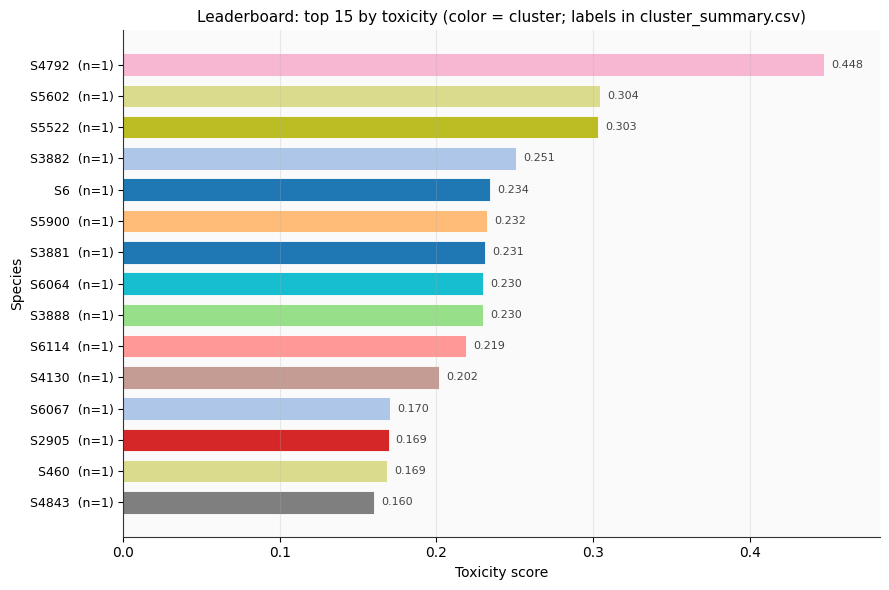

In [10]:
import pandas as pd

# --- cluster_summary: one row per species (cluster_id, n_samples, cluster_score, labels) ---
def short_labels(labels_list, k=5):
    return ", ".join((labels_list or [])[:k]) or "—"

rows = []
for sid, s in species.items():
    cid = int(s["id"]) if "id" in s else int(sid)
    n = int(s.get("size") or len(s.get("member_ids", [])))
    sc = float(s.get("max_fitness") or s.get("leader_fitness") or 0)
    lab10 = (s.get("labels") or [])[:10]
    rows.append({"cluster_id": cid, "n_samples": n, "cluster_score": sc, "labels": ", ".join(lab10) or "—", "label_short": short_labels(lab10, 5), "species_state": s.get("species_state", "active")})

df = pd.DataFrame(rows).sort_values("cluster_score", ascending=False)
(OUTPUTS / "figures").mkdir(parents=True, exist_ok=True)
df.to_csv(OUTPUTS / "figures" / "cluster_summary.csv", index=False)

# --- Leaderboard (one figure): horizontal bars, clean; colors = cluster ---
top15 = df.head(15)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
n_show = len(top15)
scores = top15["cluster_score"].values
bar_colors = [sid_to_color.get(s, "#6b8cae") for s in top15["cluster_id"]]
ypos = np.arange(n_show)
bars = ax.barh(ypos, scores, height=0.72, color=bar_colors, edgecolor="white", linewidth=0.6)
ax.set_yticks(ypos)
ax.set_yticklabels([f"S{cid}  (n={n})" for cid, n in zip(top15["cluster_id"], top15["n_samples"])], fontsize=9)
ax.set_xlabel("Toxicity score"); ax.set_ylabel("Species")
x_max = float(top15["cluster_score"].max()) or 0.5
ax.set_xlim(0, x_max * 1.08)
for i, score in enumerate(scores):
    ax.text(score + x_max * 0.01, i, f"{score:.3f}", va="center", fontsize=8, color="#444")
ax.set_title("Leaderboard: top 15 by toxicity (color = cluster; labels in cluster_summary.csv)", fontweight="medium")
ax.xaxis.grid(True, alpha=0.25)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(OUTPUTS / "figures" / "leaderboard.png", dpi=150, bbox_inches="tight")
plt.show()